In [1]:
import os
import librosa
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


2024-11-05 15:15:58.436852: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 15:15:58.444761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 15:15:58.453659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 15:15:58.456198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 15:15:58.462739: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def add_background_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    y_noisy = y + noise_factor * noise
    y_noisy = y_noisy.astype(type(y[0]))
    return y_noisy

def adjust_volume(y, factor):
    return y * factor



In [3]:
def extract_mel_spectrogram(file_path, n_mels=128, hop_length=64, fixed_length=160, sr=22050, duration=0.5, augment=False):
    """
    從音訊文件中提取梅爾頻譜圖，並進行資料增強（如果需要）。
    
    參數:
    - file_path (str): 音訊文件路徑
    - n_mels (int): 梅爾頻帶數量
    - hop_length (int): 每次窗口移動的樣本數
    - fixed_length (int): 固定的時間步數（橫向維度）
    - sr (int): 採樣率
    - duration (float): 音訊片段時長（秒）
    - augment (bool): 是否應用資料增強
    
    返回:
    - mel_spec_db (np.ndarray): 處理後的梅爾頻譜圖
    """
    try:
        # 加載音訊文件
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # 確保音訊長度固定，pad 或 truncate
        y = librosa.util.fix_length(y, size=int(sr * duration))
        
        # 資料增強
        if augment:
            augmentation_methods = ['vup', 'vdown', 'bk']
            chosen_method = np.random.choice(augmentation_methods)
            if chosen_method == 'vup':
                y = adjust_volume(y, 0.8)
        
        # 提取梅爾頻譜圖
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 填充或截斷時間步數
        if mel_spec_db.shape[1] < fixed_length:
            pad_width = fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, pad_width=((0,0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :fixed_length]
        
        # 重塑或插值至 (固定高度 x 固定寬度)
        mel_image = Image.fromarray(mel_spec_db)
        mel_image = mel_image.resize((128, fixed_length))  # (width, height)
        mel_spec_db = np.array(mel_image)
        
        return mel_spec_db.astype(np.float32)
    
    except Exception as e:
        print(f"處理文件 {file_path} 時出現錯誤: {e}")
        return None


In [4]:
def create_dataset(swallow_dir, non_dir, n_mels=128, hop_length=64, fixed_length=160, sr=22050, duration=0.5, augment=False):
    """
    建立資料集，並根據需要應用資料增強。
    
    參數:
    - swallow_dir (str): 吞嚥聲音檔案資料夾路徑
    - non_dir (str): 非吞嚥聲音檔案資料夾路徑
    - n_mels (int): 梅爾頻帶數量
    - hop_length (int): 每次窗口移動的樣本數
    - fixed_length (int): 固定的時間步數（橫向維度）
    - sr (int): 採樣率
    - duration (float): 音訊片段時長（秒）
    - augment (bool): 是否應用資料增強
    
    返回:
    - data (np.ndarray): 梅爾頻譜圖數據
    - labels (np.ndarray): 標籤數據
    """
    data = []
    labels = []
    
    # 加載吞嚥聲音檔案
    for file in os.listdir(swallow_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(swallow_dir, file)
            mel = extract_mel_spectrogram(file_path, n_mels=n_mels, hop_length=hop_length, 
                                         fixed_length=fixed_length, sr=sr, duration=duration, augment=augment)
            if mel is not None:
                data.append(mel)
                labels.append(1)
    
    # 加載非吞嚥聲音檔案
    for file in os.listdir(non_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(non_dir, file)
            mel = extract_mel_spectrogram(file_path, n_mels=n_mels, hop_length=hop_length, 
                                         fixed_length=fixed_length, sr=sr, duration=duration, augment=augment)
            if mel is not None:
                data.append(mel)
                labels.append(0)
    
    return np.array(data), np.array(labels)


In [5]:
# 定義資料夾路徑
swallow_dir = 'sound_split_data/swallow'  # 替換為實際路徑
non_dir = 'sound_split_data/non'          # 替換為實際路徑

# 建立原始訓練資料集（不應用增強）
X, y = create_dataset(swallow_dir, non_dir, sr=22050, hop_length=64, fixed_length=160, duration=0.5, augment=False)
print(f"原始資料集大小: {X.shape}, 標籤大小: {y.shape}")

# 建立增強後的訓練資料集
X_aug, y_aug = create_dataset(swallow_dir, non_dir, sr=22050, hop_length=64, fixed_length=160, duration=0.5, augment=True)
print(f"增強後資料集大小: {X_aug.shape}, 標籤大小: {y_aug.shape}")

# 合併原始資料集與增強後的資料集
X_combined = np.concatenate((X, X_aug), axis=0)
y_combined = np.concatenate((y, y_aug), axis=0)
print(f"合併後資料集大小: {X_combined.shape}, 標籤大小: {y_combined.shape}")

# 標準化
scaler = StandardScaler()
X_reshaped = X_combined.reshape(X_combined.shape[0], -1)  # (num_samples, 160*128=20480)
X_scaled = scaler.fit_transform(X_reshaped)  # (num_samples, 20480)

# 保存 scaler 以便測試階段使用
joblib.dump(scaler, 'scaler.pkl')
print("Scaler 已保存為 'scaler.pkl'")

# 重塑為 (num_samples, 160, 128, 1)
X_scaled = X_scaled.reshape(X_combined.shape[0], 160, 128, 1)

# 複製通道以符合模型要求 (num_samples, 160, 128, 3)
X_scaled = np.repeat(X_scaled, 3, axis=-1)
print(f"重塑後資料集大小: {X_scaled.shape}, 標籤大小: {y_combined.shape}")

# 拆分訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)
print(f"訓練集大小: {X_train.shape}, 驗證集大小: {X_val.shape}")


原始資料集大小: (150, 160, 128), 標籤大小: (150,)
增強後資料集大小: (150, 160, 128), 標籤大小: (150,)
合併後資料集大小: (300, 160, 128), 標籤大小: (300,)
Scaler 已保存為 'scaler.pkl'
重塑後資料集大小: (300, 160, 128, 3), 標籤大小: (300,)
訓練集大小: (240, 160, 128, 3), 驗證集大小: (60, 160, 128, 3)


In [6]:
from tensorflow.keras import layers, models

def build_simple_cnn_lstm(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # 簡單的 CNN 模塊
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)  # (80, 64, 32)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)  # (40, 32, 64)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)  # (20, 16, 128)
    x = layers.Dropout(0.3)(x)
    # Flatten 和 Dense
    x = layers.Flatten()(x)  # (20*16*128, )
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # 為 LSTM 準備序列格式
    x = layers.Reshape((1, 128))(x)  # (1, 256)
    x = layers.LSTM(64, return_sequences=False, recurrent_dropout=0.2)(x)
    
    # 輸出層
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

input_shape = (160, 128, 3)  # (fixed_length, n_mels, channels)
model = build_simple_cnn_lstm(input_shape)

# 編譯模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1730790976.534811  578383 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730790976.558091  578383 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730790976.558217  578383 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730790976.559174  578383 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,385,729 (20.54 MB)

 Trainable params: 5,385,729 (20.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9926 - loss: 0.0240 - val_accuracy: 1.0000 - val_loss: 0.0226
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9899 - loss: 0.0333 - val_accuracy: 0.9667 - val_loss: 0.0539
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 0.9667 - val_loss: 0.0400
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0185 - val_accuracy: 0.9667 - val_loss: 0.1143
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9899 - loss: 0.0175 - val_accuracy: 0.9667 - val_loss: 0.0965
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.0283
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0206
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0230


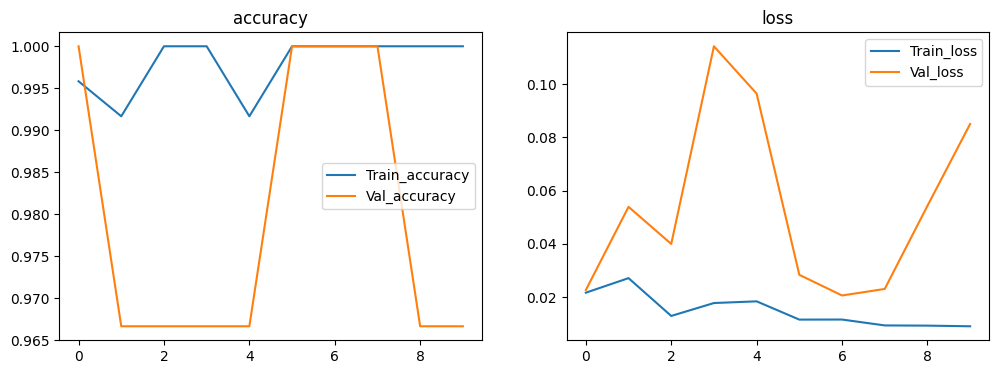

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

# 繪製訓練與驗證的準確率
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Val_accuracy')
plt.legend()
plt.title('accuracy')

# 繪製訓練與驗證的損失
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.legend()
plt.title('loss')
plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
混淆矩陣:
[[37  0]
 [ 1 22]]
分類報告:
              precision    recall  f1-score   support

 Non-Swallow       0.97      1.00      0.99        37
     Swallow       1.00      0.96      0.98        23

    accuracy                           0.98        60
   macro avg       0.99      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



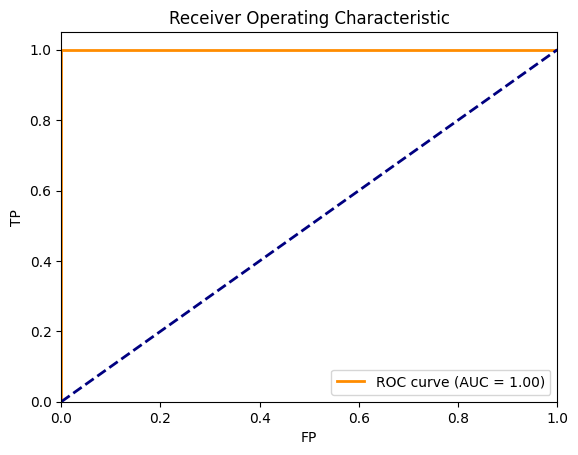

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# 在驗證集上進行預測
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.9).astype(int)
# 混淆矩陣
cm = confusion_matrix(y_val, y_pred)
print("混淆矩陣:")
print(cm)
# 分類報告
cr = classification_report(y_val, y_pred, target_names=['Non-Swallow', 'Swallow'])
print("分類報告:")
print(cr)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [19]:
def count_swallowing(file_path, model, scaler, n_mels=128, hop_length=64, fixed_length=160, sr=22050, min_interval=0.5):
    y, sr = librosa.load(file_path, duration=30, sr=sr)
    chunk_length = int(sr * 0.5)  # 分割0.5秒片段
    step_size = int(sr * 0.25)    # 回復0.25秒再分割下個片段
    count = 0
    last_swallow_time = -min_interval  # 初始化為負值
    
    for i in range(0, len(y) - chunk_length + 1, step_size):
        current_time = i / sr  # 當前片段的開始時間（秒）
        chunk = y[i:i+chunk_length]
        if len(chunk) < chunk_length:
            chunk = librosa.util.fix_length(chunk, size=chunk_length)
        
        mel_spec = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        if mel_spec_db.shape[1] < fixed_length:
            pad_width = fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(
                mel_spec_db,
                pad_width=((0,0), (0, pad_width)),
                mode='constant'
            )
        else:
            mel_spec_db = mel_spec_db[:, :fixed_length]
        
        mel_image = Image.fromarray(mel_spec_db)
        mel_image = mel_image.resize((128, fixed_length))  # (width, height)
        mel_spec_db = np.array(mel_image)
        
        X_scaled = scaler.transform(mel_spec_db.reshape(1, -1)).reshape(mel_spec_db.shape)
        X_scaled = X_scaled.reshape(1, fixed_length, n_mels, 1)
        X_scaled = np.repeat(X_scaled, 3, axis=-1)  # (1, 160, 128, 3)
        
        prediction = model.predict(X_scaled)[0][0]
        
        if prediction > 0.9:
            if (current_time - last_swallow_time) >= min_interval:
                print(f"swallow conf:{prediction:.2f} at {current_time:.2f}秒")
                count += 1
                last_swallow_time = current_time
    
    return count 

# 範例用法
file_path = '/home/bei/swallowModelTrain/音檔/測試RSST 2.wav'
num_swallow = count_swallowing(file_path, model, scaler)
print(f"吞嚥聲數量: {num_swallow}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
swallow conf:0.99 at 0.50秒
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
swallow conf:0.99 at 2.00秒
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
swallow conf:1.00 at 3.75秒
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
swallow conf:1.00 at 5.50秒
1/1 ━━━━━━━━━━━━━━

In [24]:
# 假設您的模型變量名為 model
model.save('/home/bei/swallowModelTrain/model/swallow_model.keras')
print("模型已保存為 'swallow_model.keras'")
model.save('/home/bei/swallowModelTrain/model/swallow_model.h5')
print("模型已保存為 'swallow_model.h5'")


模型已保存為 'swallow_model.keras'
模型已保存為 'swallow_model.h5'


In [32]:
import tensorflow as tf

# 1. 載入已保存的原生Keras模型
model = tf.keras.models.load_model('/home/bei/swallowModelTrain/model/swallow_model.keras')

# 2. 創建TFLite轉換器
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 3. 啟用優化（可選）
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 4. 添加 SELECT_TF_OPS
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # 內建的TFLite操作
    tf.lite.OpsSet.SELECT_TF_OPS     # 選擇性TensorFlow操作
]

# 5. 禁用 `_experimental_lower_tensor_list_ops`
converter._experimental_lower_tensor_list_ops = False  # 警告：內部API

# 6. 轉換模型
try:
    tflite_model = converter.convert()
except Exception as e:
    print("轉換失敗：", e)
    raise

# 7. 保存TFLite模型
with open('/home/bei/swallowModelTrain/tfmodel/swallow_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite模型已保存為 'swallow_model.tflite'")


/home/bei/miniconda3/envs/swallow/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 15 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


INFO:tensorflow:Assets written to: /tmp/tmpzjx9vkio/assets


INFO:tensorflow:Assets written to: /tmp/tmpzjx9vkio/assets


Saved artifact at '/tmp/tmpzjx9vkio'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  129412883658176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129412883658880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129412671213808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129412876918272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129412870923360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129412870923536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129412729286496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129412729283856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129412877217104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129412729756480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129413279388064

W0000 00:00:1730795218.841910  578383 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.


TFLite模型已保存為 'swallow_model.tflite'


W0000 00:00:1730795218.841921  578383 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-11-05 16:26:58.842021: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzjx9vkio
2024-11-05 16:26:58.842607: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-05 16:26:58.842613: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpzjx9vkio
2024-11-05 16:26:58.848542: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-05 16:26:58.889777: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpzjx9vkio
2024-11-05 16:26:58.901626: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 59605 microseconds.
2024-11-05 16:26:59.325320: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3463] TFLite interpreter needs to link Flex delegate in ord

In [33]:
import numpy as np
import tensorflow as tf

# 載入TFLite模型
interpreter = tf.lite.Interpreter(model_path='/home/bei/swallowModelTrain/tfmodel/swallow_model.tflite')
interpreter.allocate_tensors()

# 獲取輸入和輸出張量的詳細資訊
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 創建一個虛擬的輸入數據（根據您的模型輸入形狀）
input_shape = input_details[0]['shape']
input_data = np.random.random_sample(input_shape).astype(np.float32)

# 設置輸入張量
interpreter.set_tensor(input_details[0]['index'], input_data)

# 執行推論
interpreter.invoke()

# 獲取輸出張量
output_data = interpreter.get_tensor(output_details[0]['index'])
print("模型輸出：", output_data)


模型輸出： [[0.00057206]]


INFO: Created TensorFlow Lite delegate for select TF ops.
I0000 00:00:1730795293.002039  578383 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730795293.002152  578383 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730795293.002202  578383 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730795293.002277  578383 cuda